Coefficients for dx:
n=0, m=0, c=0.00018081268534791834
n=1, m=-1, c=8.965203089922658e-05
n=1, m=1, c=-0.0016213209219432926
n=2, m=-2, c=3.16277154408618e-05
n=2, m=0, c=0.00012610816272938795
n=2, m=2, c=-0.00032063603943882196
n=3, m=-3, c=-0.0002105591220457915
n=3, m=-1, c=5.17844751076836e-05
n=3, m=1, c=-0.0006507967731818832
n=3, m=3, c=-0.0003512877809393882
n=4, m=-4, c=-0.00029274509186728295
n=4, m=-2, c=4.3079206895873784e-05
n=4, m=0, c=-0.0001705910544598917
n=4, m=2, c=3.8422374020072095e-05
n=4, m=4, c=0.00022978947969139616

Coefficients for dy:
n=0, m=0, c=-0.0005454989964348058
n=1, m=-1, c=-0.0017791295739450097
n=1, m=1, c=-0.00011920347131224341
n=2, m=-2, c=2.648173332911562e-05
n=2, m=0, c=-2.260860222427038e-05
n=2, m=2, c=-0.00017287087550999986
n=3, m=-3, c=5.4622234154966365e-05
n=3, m=-1, c=-0.0006248748261022904
n=3, m=1, c=0.0002011389548510854
n=3, m=3, c=-4.792663362528721e-05
n=4, m=-4, c=-2.09992418275517e-05
n=4, m=-2, c=4.824442500434429e-05
n=4, 

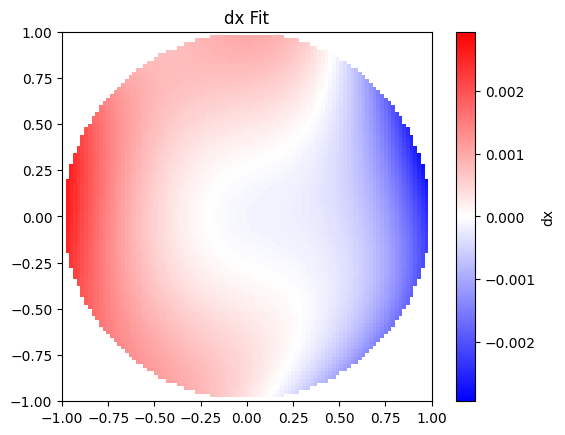

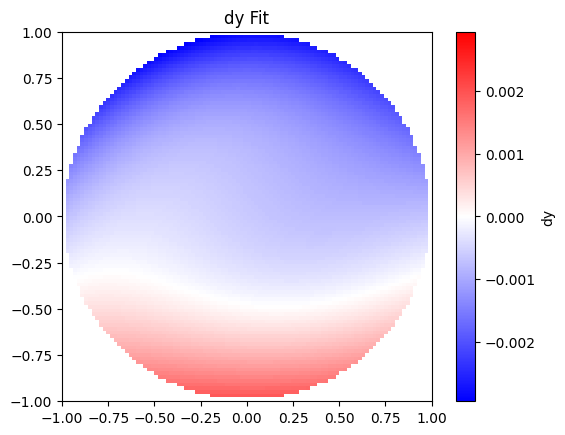

In [4]:
import numpy as np
import pandas as pd
from scipy.special import factorial
import matplotlib.pyplot as plt

def R(n, m, rho):
    """
    Compute the radial polynomial R_n^m(rho)
    """
    Rnm = np.zeros_like(rho)
    for k in range((n - abs(m)) // 2 + 1):
        c = (-1)**k * factorial(n - k) / (
            factorial(k) * factorial((n + abs(m)) // 2 - k) * factorial((n - abs(m)) // 2 - k)
        )
        Rnm += c * rho ** (n - 2 * k)
    return Rnm

def Z(n, m, rho, theta):
    """
    Compute the Zernike polynomial Z_n^m(rho, theta)
    """
    if m == 0:
        return R(n, m, rho)
    elif m > 0:
        return R(n, m, rho) * np.cos(m * theta)
    else:
        return R(n, -m, rho) * np.sin(-m * theta)

def zernike_nm_list(N):
    nm_list = []
    for n in range(N + 1):
        for m in range(-n, n + 1, 2):
            nm_list.append((n, m))
    return nm_list

def main():
    # Read data from CSV file
    data = pd.read_csv('RawData2.csv')  # Replace 'data.csv' with your file name

    x = data['wf_x'].values
    y = data['wf_y'].values
    dx = data['X_reg'].values
    dy = data['Y_reg'].values

    # Compute rho and theta
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Normalize to unit circle if necessary
    rho_max = np.max(rho)
    if rho_max > 1:
        x = x / rho_max
        y = y / rho_max
        rho = rho / rho_max
        theta = np.arctan2(y, x)

    # Remove points outside unit circle
    mask = rho <= 1
    x = x[mask]
    y = y[mask]
    rho = rho[mask]
    theta = theta[mask]
    dx = dx[mask]
    dy = dy[mask]

    # Generate Zernike polynomials
    N = 4  # Maximum order; you can adjust this value
    nm_list = zernike_nm_list(N)
    A = np.zeros((len(rho), len(nm_list)))

    for idx, (n, m) in enumerate(nm_list):
        Znm = Z(n, m, rho, theta)
        A[:, idx] = Znm

    # Perform least-squares fitting
    c_dx, residuals_dx, rank_dx, s_dx = np.linalg.lstsq(A, dx, rcond=None)
    c_dy, residuals_dy, rank_dy, s_dy = np.linalg.lstsq(A, dy, rcond=None)

    # Output the coefficients
    print("Coefficients for dx:")
    for idx, (n, m) in enumerate(nm_list):
        print(f"n={n}, m={m}, c={c_dx[idx]}")

    print("\nCoefficients for dy:")
    for idx, (n, m) in enumerate(nm_list):
        print(f"n={n}, m={m}, c={c_dy[idx]}")

    # Optionally, reconstruct the fitted surface and plot
    # Create a grid over the unit circle
    grid_size = 100
    X_grid, Y_grid = np.meshgrid(
        np.linspace(-1, 1, grid_size), np.linspace(-1, 1, grid_size)
    )
    R_grid = np.sqrt(X_grid**2 + Y_grid**2)
    Theta_grid = np.arctan2(Y_grid, X_grid)
    mask_grid = R_grid <= 1

    # Initialize fitted surfaces
    dx_fit = np.zeros_like(X_grid)
    dy_fit = np.zeros_like(X_grid)

    for idx, (n, m) in enumerate(nm_list):
        Znm_grid = Z(n, m, R_grid, Theta_grid)
        dx_fit += c_dx[idx] * Znm_grid
        dy_fit += c_dy[idx] * Znm_grid

    # Apply mask to fit results
    dx_fit[~mask_grid] = np.nan
    dy_fit[~mask_grid] = np.nan


    # Find the maximum absolute value for symmetric color limits
    max_abs_dx = np.nanmax(np.abs(dx_fit))
    max_abs_dy = np.nanmax(np.abs(dy_fit))
    vmax = max(max_abs_dx, max_abs_dy)
    vmin = -vmax

    # Plot the fitted surfaces with adjusted colormap
    plt.figure()
    plt.title('dx Fit')
    plt.imshow(dx_fit, extent=[-1, 1, -1, 1], origin='lower', cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar(label='dx')

    plt.figure()
    plt.title('dy Fit')
    plt.imshow(dy_fit, extent=[-1, 1, -1, 1], origin='lower', cmap='bwr', vmin=vmin, vmax=vmax)
    plt.colorbar(label='dy')

    plt.show()

if __name__ == '__main__':
    main()